<a href="https://colab.research.google.com/github/SmartSoundKAIST/KSNVE2022AISummer/blob/main/5_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022년 인공지능 강습회 2일차 실습 코드**
## **Practice 3 : Introduction to Anomaly Detection (Classification)**
Anomaly detection can be done by various pretext tasks. In this session, we will do anomaly detection with classification as a pretext task on the MNIST dataset. 💻

## 1. Import packages
New library imported for this project: 
- `Scikit-learn` package: includes useful tools for data analysis & preprocessing (https://scikit-learn.org/stable/)
  - We use this package for `anomaly score` metrics
- `Matplot` library: for plotting graphs
- `Torchinfo`: summarizes and print formatted `model information` 

In [ ]:
!pip install torchinfo # install torchinfo module 

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn import metrics
from sklearn.manifold import TSNE 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import cm
import torchsummary
from torchinfo import summary
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
plt.rc('font', size=20)

## 2. Hyperparameters
You can change the hyperparameter below.
Parameter `ANOMALY_NUM` means which number to set as an anomaly.

In [ ]:
EPOCHS = 5          # Number of epochs to train
BATCH = 32          # Minibatch size
ORGCLASS_NUM = 10   # Num of original classes (10: 0 to 9)
ANOMALY_NUM = [7,8,9]   # (list) Digits will be used as anomalous data
NORMAL_NUM =  [0,1,2,3]   # (list) Digits used as normal data  

TEMPSC = 1.0    # temperature parameter (for temperature scaling)
LBSMOOTH = 0.0  # label smoothing parameter

The dataset for anomaly detection is composed of normal data and anomaly data. Normal data can be seen in the train, validation, and test dataset, but anomaly data is not in the train dataset. Here digit `0,1,2,3` will be used as `normal data`, and `7,8,9` will be used as `anomaly data`. 
`TEMPSC` and `LBSMOOTH` are parameters for temperature scaling and label smoothing, respectively.

## 3. Dataset and Dataloader

Here we use MNIST dataset. 
The datatype of the dataset is a TorchTensor of tuples: (`image tensor`, `target label`)

The dimensions of an image tensor is (`channel`=1, `width`=28, `height` =28)

Here, we use `Subset` package in `torch.utils.data` to build two sub-datasets (validation, test).


In [ ]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_idx = [i for i,v in enumerate(mnist_train) if v[1] in NORMAL_NUM]         # get a list of indices with NORMAL_NUM, v is the tuple of (image tensor, label)
train_dataset = Subset(mnist_train,train_idx)                                   # get a subset of dataset using train_idx
                                     
testdigit = ANOMALY_NUM + NORMAL_NUM                                                # join two list
test_idx =[i for i,v in enumerate(mnist_test) if v[1] in testdigit]
Num_test = int(len(test_idx)/2)

test_dataset = Subset(mnist_test,test_idx[:Num_test])
val_dataset = Subset(mnist_test,test_idx[Num_test:])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)


Dataset length is like below.

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

24754
3584
3584


## 4. Define a DNN model 
Now, you will use CNN classifier.

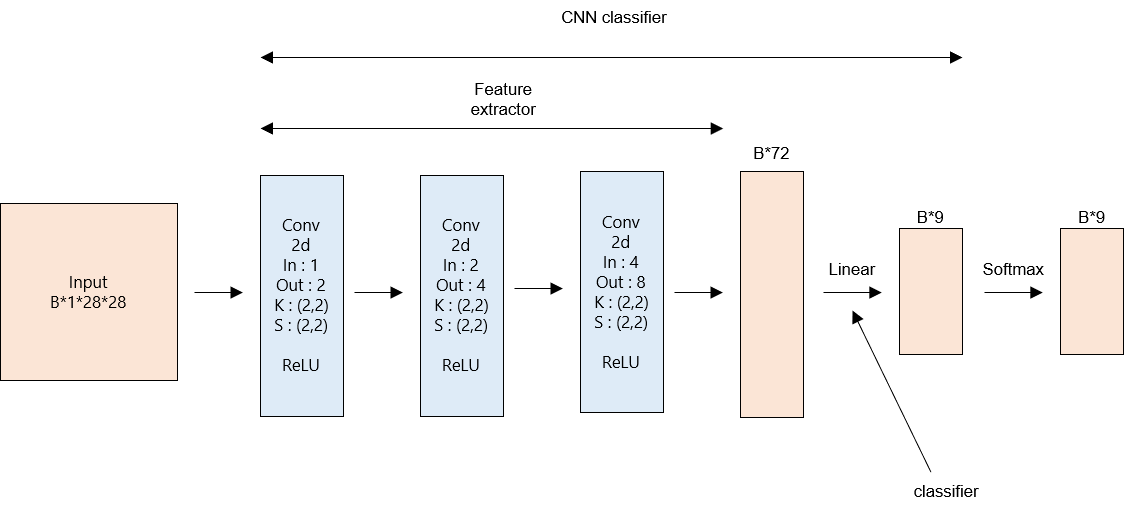

In [ ]:
class ClassificationCNNModel(nn.Module):
    def __init__(self, nclass=len(NORMAL_NUM)):
        super(ClassificationCNNModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,2,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(2,4,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(4,8,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(72,nclass),
        )

    def forward(self, x):
        feature = self.feature_extractor(x)
        feature = feature.reshape(feature.shape[0],-1)
        out = self.classifier(feature)
        return out, feature

In [ ]:
## Create classification object 
model = ClassificationCNNModel(len(NORMAL_NUM)).to(device)
summary(model,input_size=(BATCH,1,28,28)) # summary(model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
ClassificationCNNModel                   --                        --
├─Sequential: 1-1                        [32, 8, 3, 3]             --
│    └─Conv2d: 2-1                       [32, 2, 14, 14]           10
│    └─ReLU: 2-2                         [32, 2, 14, 14]           --
│    └─Conv2d: 2-3                       [32, 4, 7, 7]             36
│    └─ReLU: 2-4                         [32, 4, 7, 7]             --
│    └─Conv2d: 2-5                       [32, 8, 3, 3]             136
│    └─ReLU: 2-6                         [32, 8, 3, 3]             --
├─Sequential: 1-2                        [32, 4]                   --
│    └─Linear: 2-7                       [32, 4]                   292
Total params: 474
Trainable params: 474
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.27

### Loss functions & optimizers & Anomaly Score

Loss function is Cateogrical Cross Entropy. This loss is commonly used for multi-class classification. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

This function gets Softmax probability and a target one-hot vectoras input.

Anomaly score is then calculated in validation and test. 1 - Maximum Softmax Probability is commonly used as an anomaly score when using classification as a pretext task. Since the model has the label of normal only, the model may predict anomaly data as a normal class with lower probability (Under-confident).

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=LBSMOOTH) # CCE
def anomaly_score(logits): # Anomaly score = 1 - MSP
    softmaxprob = torch.softmax(logits, dim=1)
    MSP = torch.max(softmaxprob, dim=1).values
    return torch.tensor(1) - MSP
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam as optimizer

## 5. Train & Test classes
The design of train & test classes is quite similar to previous examples. 

### Train

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    losses = []
    for batch, dat in enumerate(dataloader):                   # dat is tuple of (img, label)
        logits, _ = model(dat[0].to(device))                      # logit (batch, class)
        
        p = F.one_hot(dat[1],ORGCLASS_NUM)[:,NORMAL_NUM] 
        p = p.float().to(device)
     
        loss = loss_fn(logits, p)    
        losses.append(loss.cpu().detach())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * logits.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return np.mean(losses)

Anomaly score is calculated over validation and test datasets. Since the model is trained with normal data, the model may not classify anomaly data with high confidence, so the anomaly score of anomaly data will be higher than the anomaly score of normal data. Using difference in anomaly score distributions, ROC-AUC (Area Under Curve) can be calculated.

### Test

In [ ]:
def test(dataloader, model, loss_fn, anomaly_score, valid_mode = True,  draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    normal_scores = []
    anomaly_scores  =[]
    outfeature = []  
    total_labels = []

    with torch.no_grad():
      
        for Imgs, labels in dataloader:

            Imgs = Imgs.to(device)                    # upload to GPU
            logits, features = model(Imgs)            # logits out (idx,class), features out (idx, num_feature )
            logits = logits/TEMPSC                   # temperature scaling
            if not valid_mode:
                outfeature.append(features)              # append features to tensor list for t-SNE plot 
                total_labels.append(labels)

            score = anomaly_score(logits)            # anomaly score (idx)
            
            # We do nothing if label does not belong to NORMAL_NUM or ANOMALY_NUM
            for idata in range(logits.shape[0]):
                score_ = score[idata].item()
                if labels[idata] in NORMAL_NUM:  # for normal data

                    # calc CE loss for normal data
                    p = F.one_hot(labels[idata],10)[NORMAL_NUM].reshape(1,-1)
                    logit = logits[idata,:].reshape(1,-1)
                    loss = loss_fn(logit.to(device), p.float().to(device)) # Cross-Entropy loss for normal
                    normal_loss.append(loss.cpu())
                    
                    # record scores
                    y_true.append(0.)
                    y_pred.append(score_)
                    normal_scores.append(score_)

                elif labels[idata] in ANOMALY_NUM: # for abnormal data
                    y_true.append(1.)
                    y_pred.append(score_)
                    anomaly_scores.append(score_)
            
        roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')
    
    normal_loss_mean = np.mean(normal_loss)
    normal_score_mean = np.mean(normal_scores)
    anomaly_score_mean = np.mean(anomaly_scores)

    print(f'normal loss : {normal_loss_mean}')
    if not valid_mode:
      outfeature = torch.cat(outfeature, dim=0).cpu().numpy()
      total_labels = torch.cat(total_labels, dim=0).cpu().numpy()
    return roc_auc.item(), normal_loss_mean, normal_score_mean, anomaly_score_mean, normal_scores, anomaly_scores, outfeature, total_labels

## 6. Run Trainer 
Now all the classes are defined. Let's see how classification loss and AUC changes during training.

Loss is calculated during train, and AUC is calculated during validation.

In [ ]:
train_losses = []
val_normal_losses= []
val_normal_scores = []
val_anomaly_scores = []
roc_auc = []

best_auc = 0.0
best_model = model.to(device)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc,val_normal_loss, val_normal_score, val_anomaly_score, _, _, _, _ = test(val_dataloader, model, loss_fn, anomaly_score, valid_mode=True)

    train_losses.append(train_loss)
    val_normal_losses.append(val_normal_loss)
    val_normal_scores.append(val_normal_score)
    val_anomaly_scores.append(val_anomaly_score)

    roc_auc.append(auc)

    if auc > best_auc:
        best_model,  best_auc = model,  auc

Epoch 1
-------------------------------
loss: 1.381678  [    0/24754]
loss: 0.105808  [ 9600/24754]
loss: 0.122438  [19200/24754]
AUC: 0.916
normal loss : 0.07561328262090683
Epoch 2
-------------------------------
loss: 0.177398  [    0/24754]
loss: 0.111292  [ 9600/24754]
loss: 0.046926  [19200/24754]
AUC: 0.918
normal loss : 0.05596350133419037
Epoch 3
-------------------------------
loss: 0.069018  [    0/24754]
loss: 0.039976  [ 9600/24754]
loss: 0.229392  [19200/24754]
AUC: 0.924
normal loss : 0.04564304277300835
Epoch 4
-------------------------------
loss: 0.081558  [    0/24754]
loss: 0.019993  [ 9600/24754]
loss: 0.038939  [19200/24754]
AUC: 0.922
normal loss : 0.03892643004655838
Epoch 5
-------------------------------
loss: 0.024949  [    0/24754]
loss: 0.005281  [ 9600/24754]
loss: 0.022333  [19200/24754]
AUC: 0.935
normal loss : 0.03545031324028969


#### Plot train results

<Figure size 432x288 with 0 Axes>

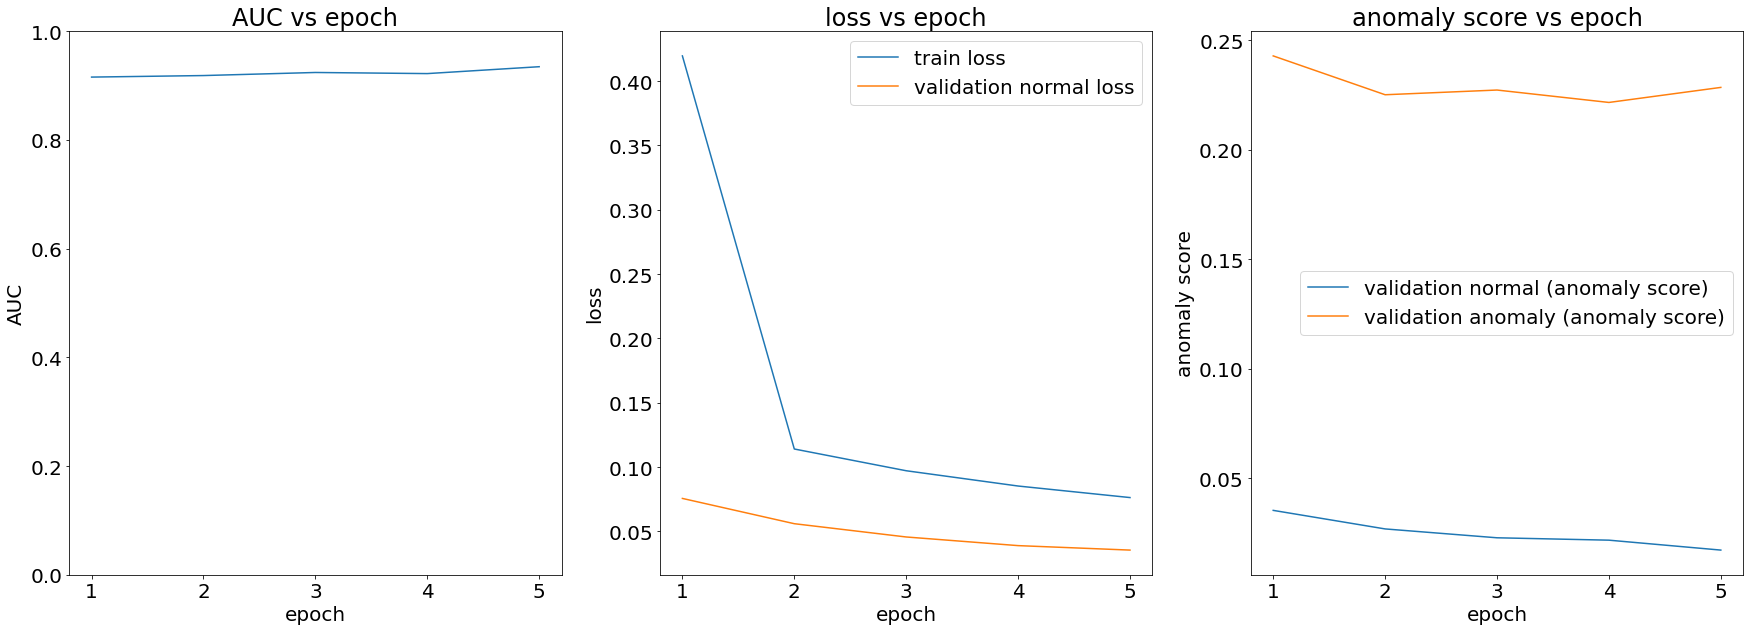

In [ ]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(roc_auc)+1)),roc_auc)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_losses)+1)),train_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_scores)+1)),val_normal_scores)
plt.plot(list(range(1,len(val_anomaly_scores)+1)),val_anomaly_scores)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal (anomaly score)','validation anomaly (anomaly score)'])

## 7. Performance on test data.
### 7-1. ROC-AUC

AUC: 0.914
normal loss : 0.07150780409574509


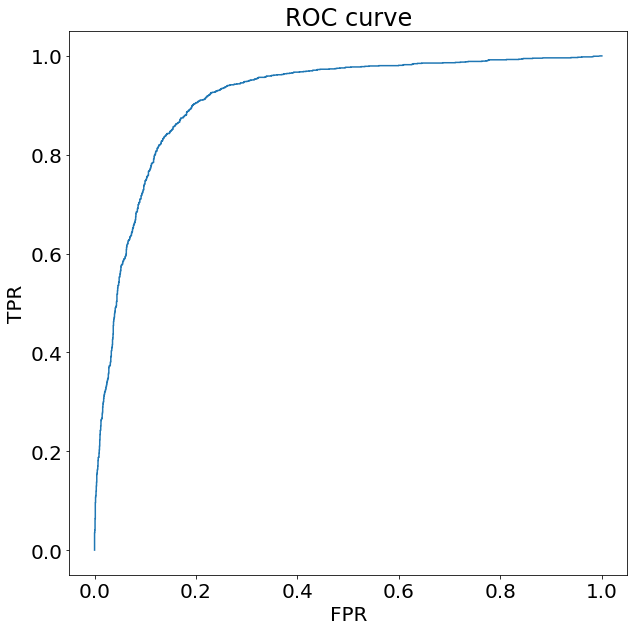

In [ ]:
test_auc,test_normal_loss, test_normal_score, test_anomaly_score, test_normal_scores, test_anomaly_scores, best_features, total_labels \
= test(test_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=True)

### 7-2. Histogram of anomaly score 

<Figure size 720x720 with 0 Axes>

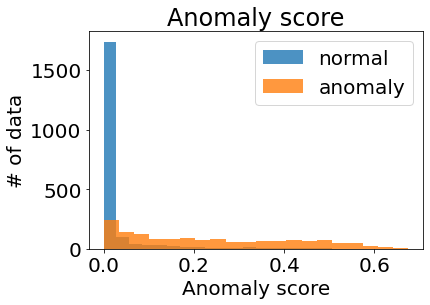

<Figure size 720x720 with 0 Axes>

In [ ]:
#@title 기본 제목 텍스트
plt.hist(test_normal_scores,  bins = 20, alpha = 0.8) # 'bins' are related to the number of bins.
plt.hist(test_anomaly_scores, bins = 20, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

## 8. Image comparison 

Below code plots figure of the original input image and predicted probability for each class.

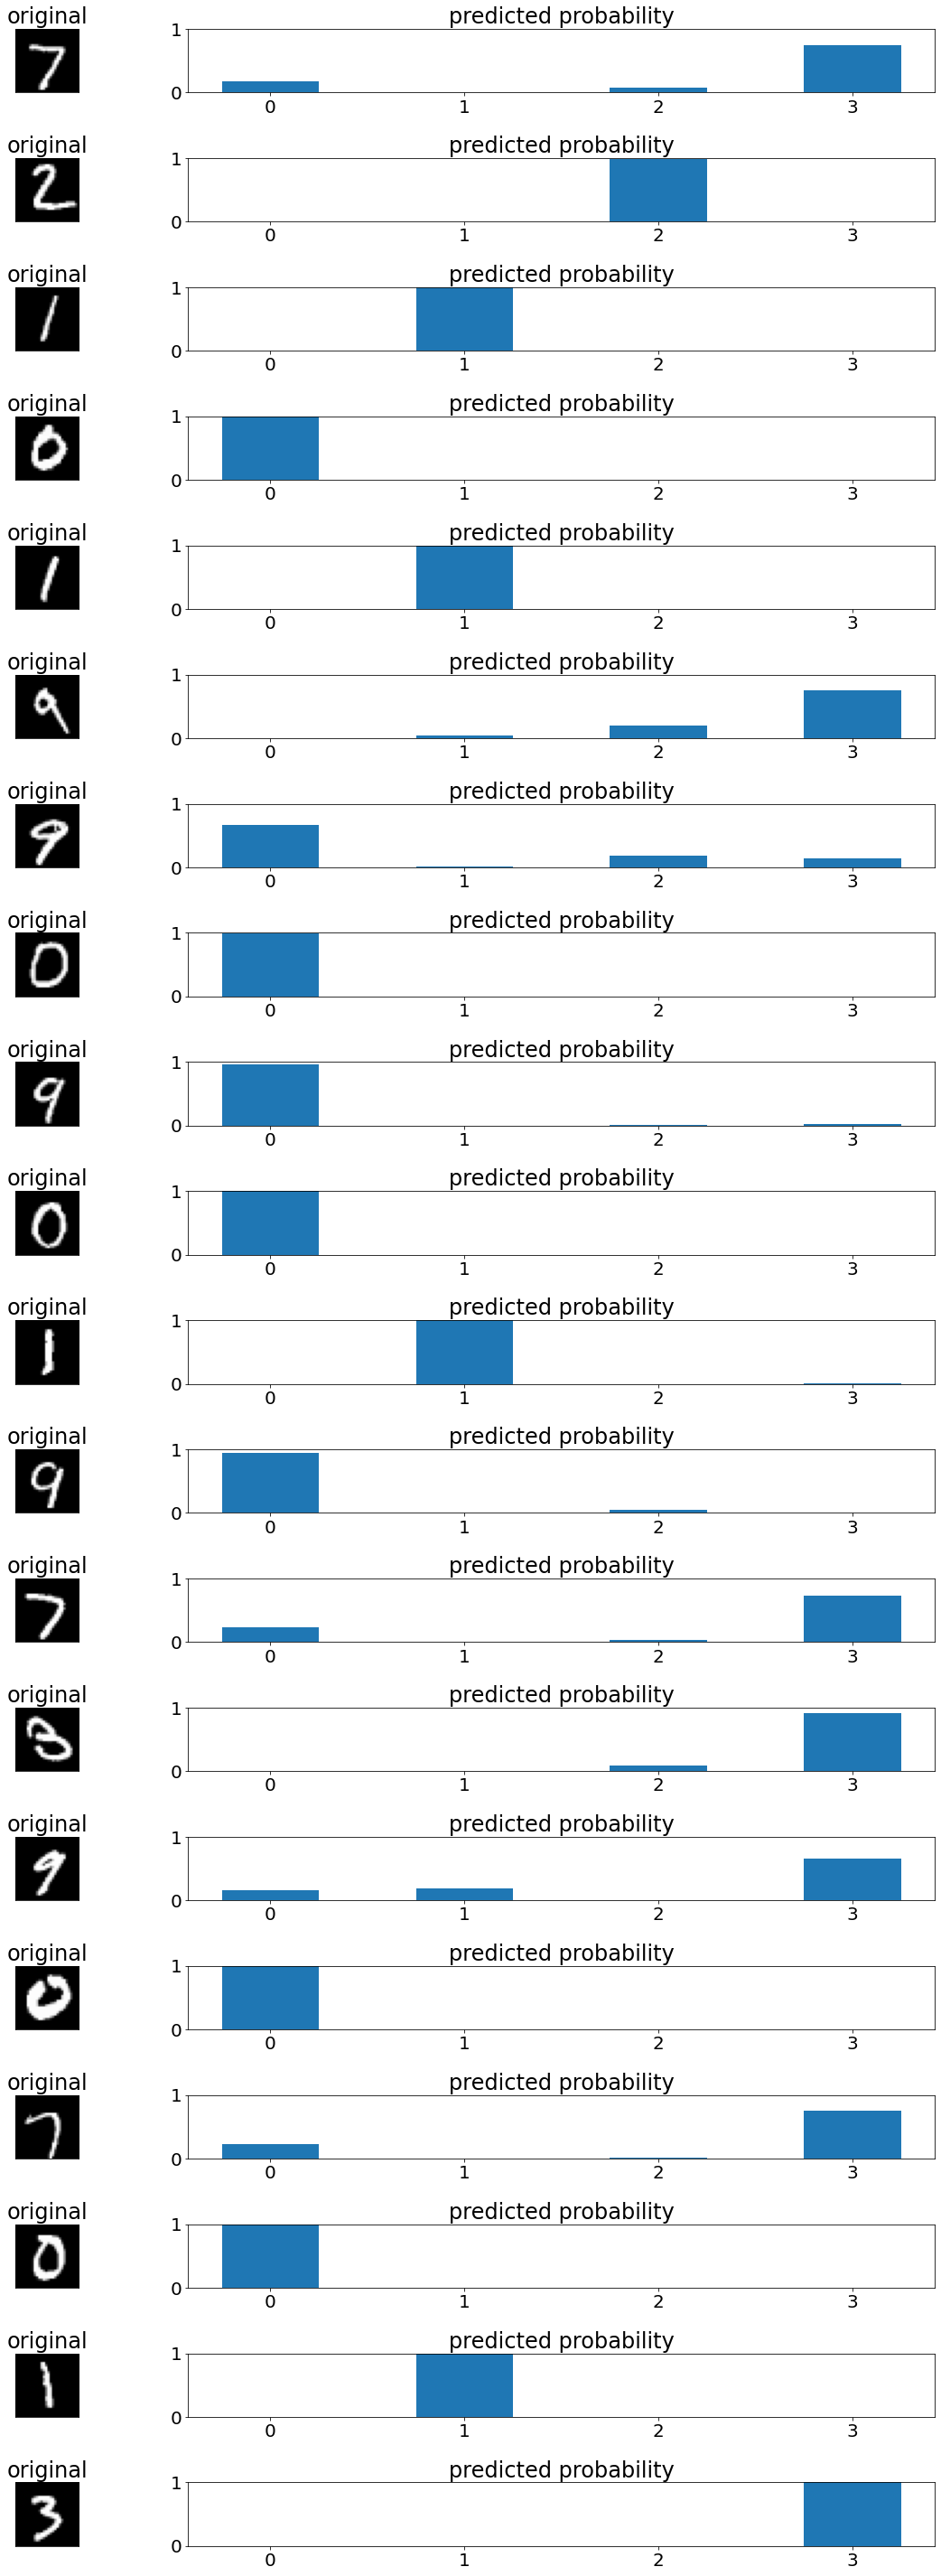

In [ ]:
n = 20 # the number of data to be plotted
plt.figure(figsize=(20, 40)) # total figure size

for i in range(n):
    input_image = test_dataset[i][0].to(device)
    pred_prob = torch.softmax(best_model(input_image.unsqueeze(0))[0],dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu()) # show input image
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])

    classify_as = [str(i) for i in NORMAL_NUM]
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = classify_as) # print predicted probability for each class

    plt.title('predicted probability')
    plt.tight_layout()

plt.show()

As you see, normal data (0 to 8) is predicted with a high probability compared to anomaly data (9). 

This means normal data have higher MSP, which is anomaly score, and anomaly data have lower MSP.

Using this difference of anomaly score, anomaly detection can be done.

# 9. t-SNE visualization 
Here, we visualize the feature space using t-SNE visualization tool

In [ ]:
# Create a two dimensional t-SNE projection of the feature embeddings
tsne = TSNE(2, verbose=1) #2D visualization
tsne_proj = tsne.fit_transform(best_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3584 samples in 0.001s...
[t-SNE] Computed neighbors for 3584 samples in 0.374s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3584
[t-SNE] Computed conditional probabilities for sample 2000 / 3584
[t-SNE] Computed conditional probabilities for sample 3000 / 3584
[t-SNE] Computed conditional probabilities for sample 3584 / 3584
[t-SNE] Mean sigma: 2.637083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.136917
[t-SNE] KL divergence after 1000 iterations: 1.389903


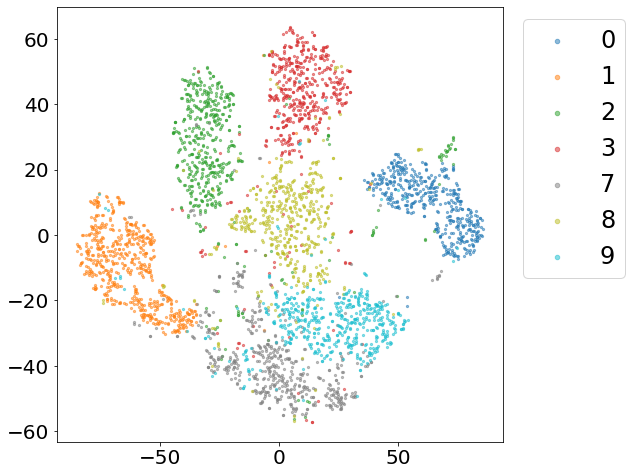

In [ ]:
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,8))
TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM
num_categories = len(TOTAL_NUM)
for ilabel in TOTAL_NUM:
    indices = total_labels==ilabel
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
plt.show()